# Deep Learning Final Project
## Kelompok 8 - LB01

- Jessica Priscilla Immanuel (2702246163)
- Marsha Genevieve Nandana (2702217522)
- Ricardo Cuthbert (2702353612)

In [ ]:
pip install pytesseract

# 1. Import library



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Concatenate
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from tensorflow.keras.losses import MeanAbsoluteError
from google.colab import drive
drive.mount('/content/drive')
import random

#evaluation
from skimage.metrics import peak_signal_noise_ratio, structural_similarity

#model OCR buat cek bagus blm hasil denoising documentnya
from PIL import Image
import pytesseract

Mounted at /content/drive


# 2. Load gambar dan preprocessing


In [ ]:
INPUT_DIR = '/content/drive/MyDrive/Finpro_DeepLearning/denoising-dirty-documents/train'
TARGET_DIR = '/content/drive/MyDrive/Finpro_DeepLearning/denoising-dirty-documents/train_cleaned'

#kita tidak meresize gambar jadi 256x256 (karena bikin buram), tapi kita crop ukuran 256x256 dari resolusi asli
IMG_SIZE = (256, 256)

#ambil 10 potongan acak dari setiap halaman dokumen, kalau punya 100 gambar asli, total data training jadi 1.000 (100 x 10)
#jumlah 10 sesuain aja tr
PATCHES_PER_IMAGE = 10

def load_images_patches(input_path, target_path):
    input_patches = []
    target_patches = []

    input_files = sorted(os.listdir(input_path)) #kalau tidak disort, takutnya pairnya jadi berantakan
    target_files = sorted(os.listdir(target_path))

    print(f"processingfrom {input_path}")

    for f in input_files:
        if f in target_files:

            #kita baca gambar full size (misal: 3000x2000 pixel) & pake grayscale
            img_in_full = cv2.imread(os.path.join(input_path, f), cv2.IMREAD_GRAYSCALE)
            img_tar_full = cv2.imread(os.path.join(target_path, f), cv2.IMREAD_GRAYSCALE)


            if img_in_full is None: continue #kalau gambar corrupt/gak bisa dibaca skip aja
            h, w = img_in_full.shape #image's dimensions

            #ulang sebanyak sesuai PATCHES_PER_IMAGE
            for _ in range(PATCHES_PER_IMAGE):
                if h < IMG_SIZE[0] or w < IMG_SIZE[1]: continue #kalau gambar aslinya lebih kecil dari 256x256 skip

                #cari titik koordinat acak (random coordinate), kita pilih titik pojok kiri atas (y, x) secara random
                rand_y = random.randint(0, h - IMG_SIZE[0])
                rand_x = random.randint(0, w - IMG_SIZE[1]) #batasnya dikurangi IMG_SIZE biar croppingnya ngga keluar jalur

                #slicing array, ambil window ukuran 256x256 mulai dari titik random tadi, karena tidak ada resize, tulisan di dalam kotak ini tetep resoulsi aslinya
                patch_in = img_in_full[rand_y : rand_y+IMG_SIZE[0], rand_x : rand_x+IMG_SIZE[1]]
                patch_tar = img_tar_full[rand_y : rand_y+IMG_SIZE[0], rand_x : rand_x+IMG_SIZE[1]]
                input_patches.append(patch_in)
                target_patches.append(patch_tar)


    input_patches = np.array(input_patches, dtype='float32') / 255.0 #standard deep learning || normalizations
    target_patches = np.array(target_patches, dtype='float32') / 255.0

    #reshape dimensi biar diterima CNN, = jumlah data, tinggi, lebar, channel
    input_patches = input_patches.reshape(-1, IMG_SIZE[0], IMG_SIZE[1], 1) #channel = 1 karena gray
    target_patches = target_patches.reshape(-1, IMG_SIZE[0], IMG_SIZE[1], 1)

    print(f"good. shape: {input_patches.shape}")
    return input_patches, target_patches



#90:10
X, y = load_images_patches(INPUT_DIR, TARGET_DIR)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

processingfrom /content/drive/MyDrive/Finpro_DeepLearning/denoising-dirty-documents/train
good. shape: (1440, 256, 256, 1)


# 3. Membuat model U-Net

In [ ]:
def build_unet(input_shape):
    inputs = Input(input_shape)

    #ENCODER#
    #detail halus: serat kertas, pinggiran huruf
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    #bentuk huruf & kata
    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    #BOTTLENECK#
    b = Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    b = Conv2D(256, (3, 3), activation='relu', padding='same')(b)

    #DECODER#
    #upsample 1
    u1 = UpSampling2D((2, 2))(b)
    u1 = Concatenate()([u1, c2])
    #64 128 256
    c3 = Conv2D(128, (3, 3), activation='relu', padding='same')(u1)
    c3 = Conv2D(128, (3, 3), activation='relu', padding='same')(c3)

    #upsample 2
    u2 = UpSampling2D((2, 2))(c3)
    u2 = Concatenate()([u2, c1])
    #32 64 128
    c4 = Conv2D(64, (3, 3), activation='relu', padding='same')(u2)
    c4 = Conv2D(64, (3, 3), activation='relu', padding='same')(c4)

    #output layer
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c4)

    model = Model(inputs=[inputs], outputs=[outputs])
    return model

modelU = build_unet((256, 256, 1))
modelU.compile(optimizer='adam', loss='binary_crossentropy') #compile ttp pakai binary_crossentropy karena data kita patch-based (yang harusnya sharp)
modelU.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │        640 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │     36,928 │ conv2d[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │    147,584 │ conv2d_2[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 64, 64,    │    590,080 │ conv2d_4[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d       │ (None, 128, 128,  │          0 │ conv2d_5[0][0]    │
│ (UpSampling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 128, 128,  │          0 │ up_sampling2d[0]… │
│ (Concatenate)       │ 384)              │            │ conv2d_3[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 128, 128,  │    442,496 │ concatenate[0][0] │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 128, 128,  │    147,584 │ conv2d_6[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_1     │ (None, 256, 256,  │          0 │ conv2d_7[0][0]    │
│ (UpSampling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 256, 256,  │          0 │ up_sampling2d_1[… │
│ (Concatenate)       │ 192)              │            │ conv2d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 256, 256,  │    110,656 │ concatenate_1[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 256, 256,  │     36,928 │ conv2d_8[0][0]  

 Total params: 1,881,985 (7.18 MB)

 Trainable params: 1,881,985 (7.18 MB)

 Non-trainable params: 0 (0.00 B)

# 4. Training model


Epoch 1/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 222s 3s/step - loss: 0.3660 - val_loss: 0.1287
Epoch 2/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - loss: 0.1205 - val_loss: 0.1013
Epoch 3/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - loss: 0.1020 - val_loss: 0.0968
Epoch 4/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 84s 1s/step - loss: 0.0978 - val_loss: 0.0940
Epoch 5/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - loss: 0.0954 - val_loss: 0.0929
Epoch 6/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - loss: 0.0940 - val_loss: 0.0918
Epoch 7/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - loss: 0.0924 - val_loss: 0.0910
Epoch 8/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 83s 1s/step - loss: 0.0918 - val_loss: 0.0903
Epoch 9/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - loss: 0.0912 - val_loss: 0.0897
Epoch 10/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - loss: 0.0911 - val_loss: 0.0898
Epoch 11/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - loss: 0.0907 - val_loss: 0.0891
Epoch 12/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - loss: 0.0902 - val_l

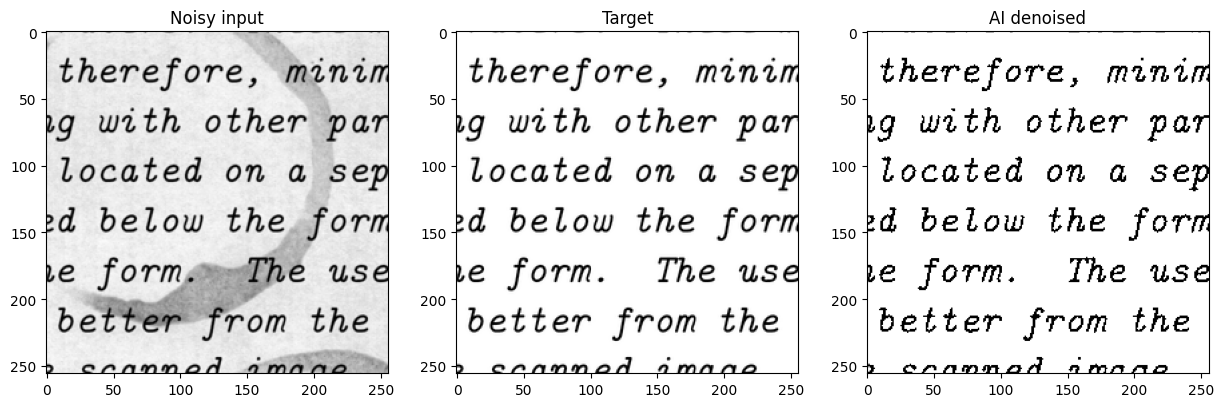

In [ ]:
#training
history = modelU.fit( #ganti dsni modelnya
    X_train, y_train,
    epochs=50, #25 50
    batch_size=32, #16 20 32
    shuffle=True,
    validation_data=(X_test, y_test)
)


def show_prediction(index_img):
    noisy_image = X_test[index_img]

    #expand dmensions
    pred = modelU.predict(np.expand_dims(noisy_image, axis=0)) #ganti dsni modelnya
    pred_sharp = (pred > 0.5).astype(np.float32)

    plt.figure(figsize=(15, 5))
    #noisy
    plt.subplot(1, 3, 1)
    plt.title("Noisy input")
    plt.imshow(noisy_image.reshape(256, 256), cmap='gray')
    #clean
    plt.subplot(1, 3, 2)
    plt.title("Target")
    plt.imshow(y_test[index_img].reshape(256, 256), cmap='gray')

    #prediction
    plt.subplot(1, 3, 3)
    plt.title("AI denoised")
    plt.imshow(pred_sharp.reshape(256, 256), cmap='gray')

    plt.show()


show_prediction(0)

# 5. Evaluasi model

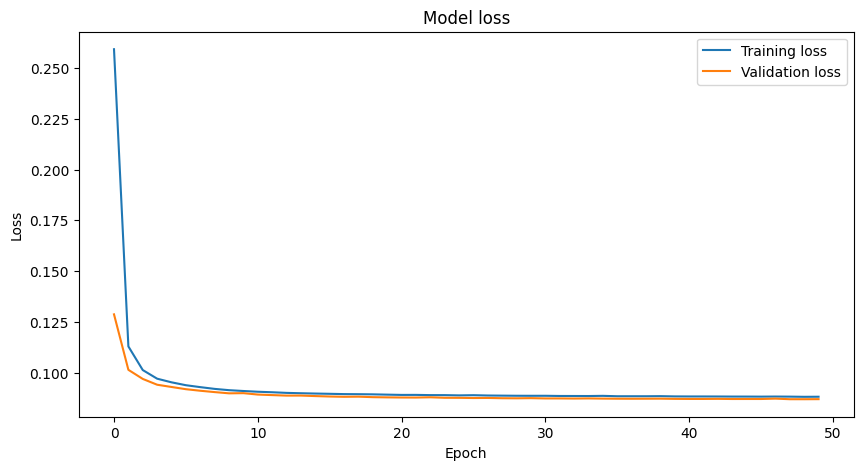

Test loss: 0.0869


In [ ]:
#plotting
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

#eval
loss = modelU.evaluate(X_test, y_test, verbose=0)
print(f"Test loss: {loss:.4f}")

In [ ]:
#testing
predicted_images = modelU.predict(X_test)
psnr_scores = []
ssim_scores = []

#loop setiap gambar di training set
for i in range(len(X_test)):
    true_image = y_test[i] #clean image & gambar prediksi
    denoised_image = predicted_images[i]

    #apus dimensi channel jika gambar grayscale (misal dari (256, 256, 1) jd (256, 256))
    true_image = true_image.squeeze()
    denoised_image = denoised_image.squeeze()

    #PSNR
    psnr = peak_signal_noise_ratio(true_image, denoised_image, data_range=1.0) #data_range -> rentang dynamic pixel value (misal, 1.0 untuk float [0,1])
    psnr_scores.append(psnr)

    #SSIM
    ssim = structural_similarity(true_image, denoised_image, data_range=1.0) #data_range=1.0 untuk gambar float [0,1]
    ssim_scores.append(ssim)

#hasil evaluasi
print(f"Average PSNR: {np.mean(psnr_scores):.4f}")
print(f"Average SSIM: {np.mean(ssim_scores):.4f}")

5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 289ms/step
Average PSNR: 38.4898
Average SSIM: 0.9981


Hasil yang didapatkan oleh model, yaitu
1. PSNR = 38.4898 sudah sangat baik karena nilai yang jadi penentu, yaitu
- PSNR > 40, Sangat mirip dengan yang asli
- PSNR > 30, Kualitas sangat baik

2. SSIM = 0.9981 sudah sangat baik karena nilai yang jadi penentu, yaitu antara -1 dan 1. Hasil yang didapat mendekati 1 berarti model membuat struktur gambar yang hampir mirip dengan aslinya.


# 6. Simpan model
Model disimpan untuk digunakan pada streamlit.

In [ ]:
#save model
drive_file_path = '/content/drive/My Drive/Finpro_DeepLearning/denoising-dirty-documents/'
modelU.save(os.path.join(drive_file_path, 'denoising_unet_model_lighter.h5'))
print("good")

good


# 7. Menampilkan hasil gambar prediksi yang sudah dialkukan denoising

Top 5 best predition:
img index ke-121, SSIM: 0.9992
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


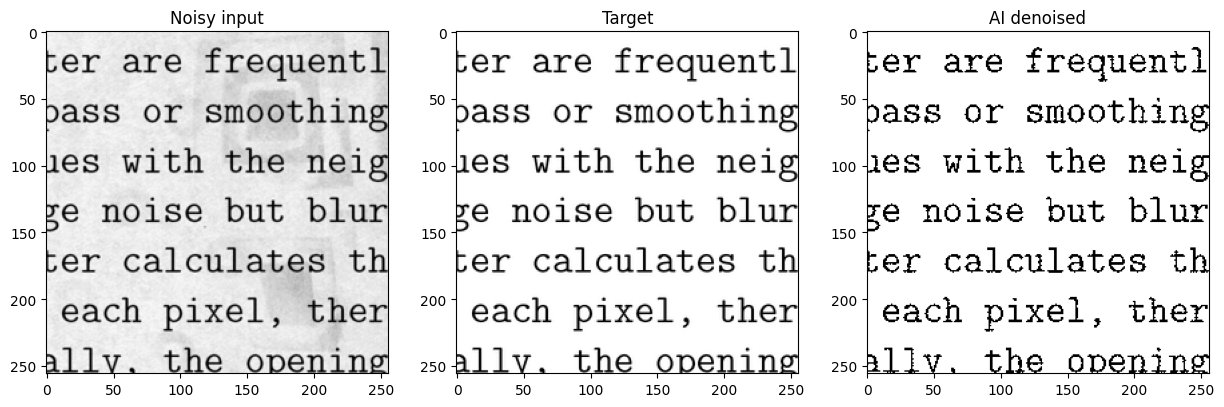

img index ke-18, SSIM: 0.9992
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


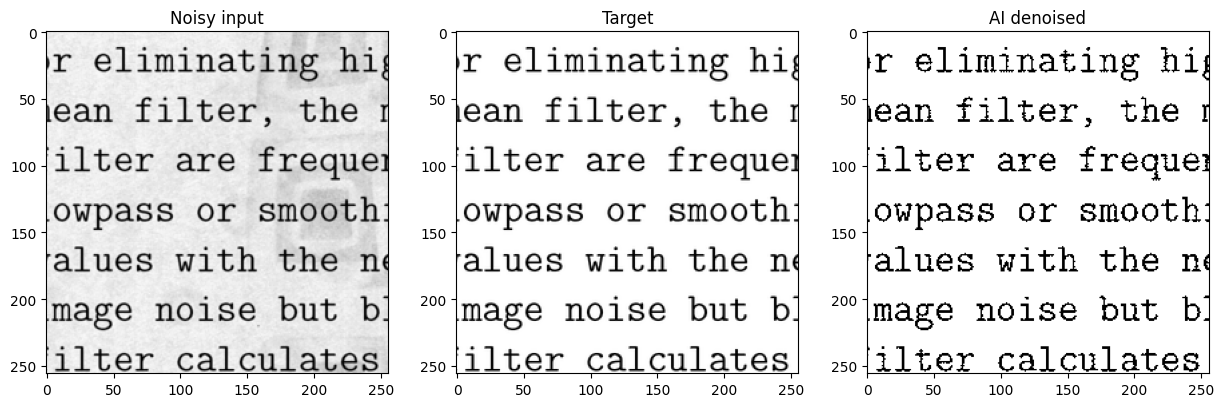

img index ke-134, SSIM: 0.9992
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


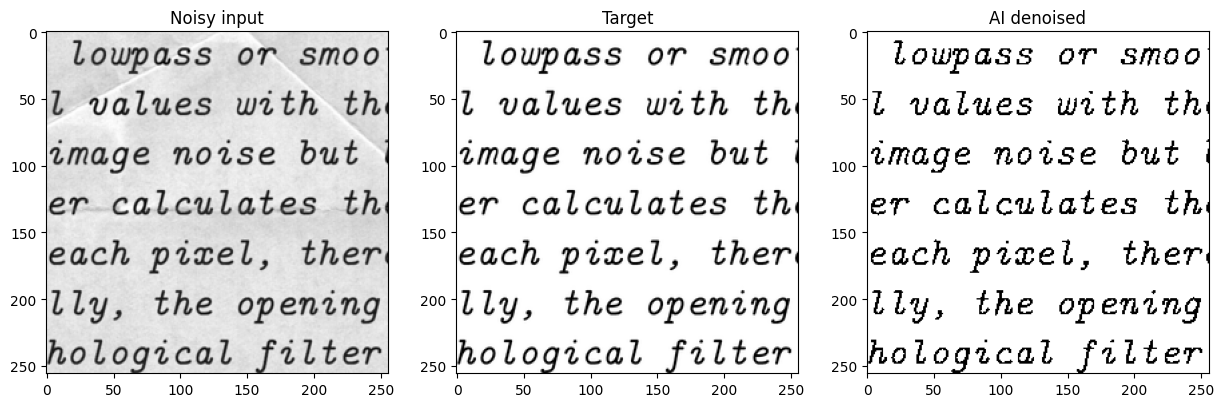

img index ke-59, SSIM: 0.9992
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


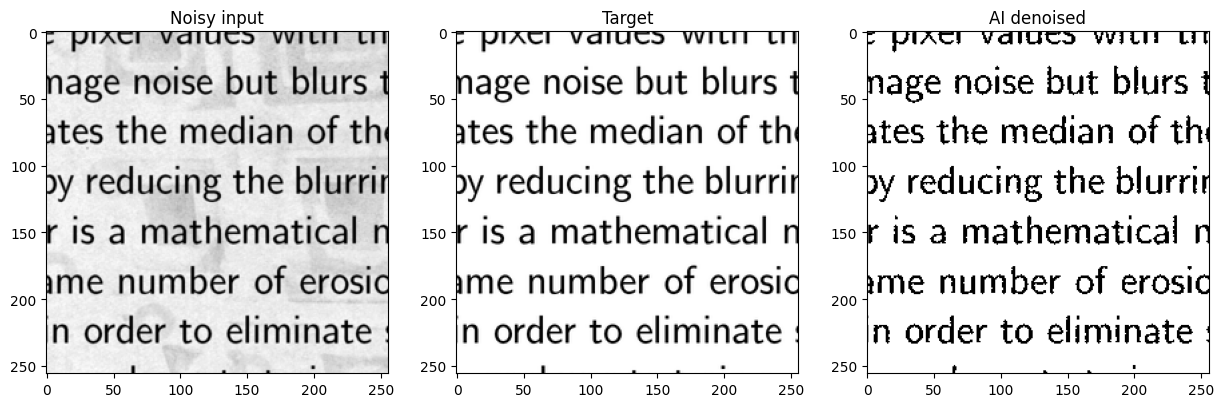

img index ke-7, SSIM: 0.9992
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


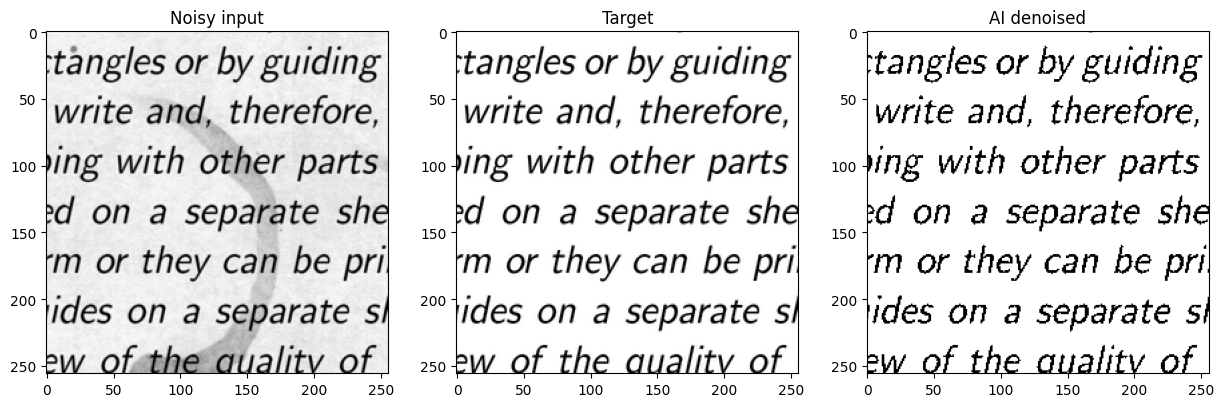

In [ ]:
#5 gambar dengan SSIM paling tinggi
if 'ssim_scores' in locals() or 'ssim_scores' in globals():
    sorted_indices = np.argsort(ssim_scores)[::-1]

    print("Top 5 best predition:")
    top_5_indices = sorted_indices[:5]

    for idx in top_5_indices:
        print(f"img index ke-{idx}, SSIM: {ssim_scores[idx]:.4f}")
        show_prediction(idx)
else:
    print("fail")

Best denoised image (by SSIM) saved at: /content/drive/My Drive/Finpro_DeepLearning/denoising-dirty-documents/best_denoised_image.png, idx in x_test: 121
Best SSIM: 0.9992
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


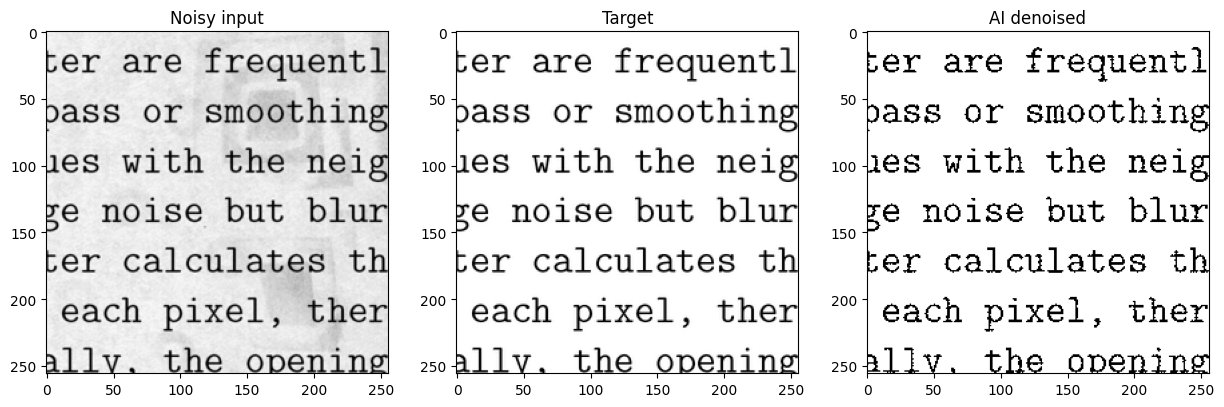

In [ ]:
#save yg paling bagus
best_ssim_index = np.argmax(ssim_scores)
best_denoised_image = predicted_images[best_ssim_index]
best_denoised_image = best_denoised_image.squeeze() #hapus dimensi channel kl gambar grayscale (misal dari (256, 256, 1) jd (256, 256))
best_denoised_image_uint8 = (best_denoised_image * 255).astype(np.uint8) #convert to uint8 [0, 255]

save_path = os.path.join(drive_file_path, 'best_denoised_image.png')
cv2.imwrite(save_path, best_denoised_image_uint8)

print(f"Best denoised image (by SSIM) saved at: {save_path}, idx in x_test: {best_ssim_index}")
print(f"Best SSIM: {ssim_scores[best_ssim_index]:.4f}")
show_prediction(best_ssim_index)

# 8. Test hasil denoising dengan model OCR, apakah berhasil denoisingnya


In [ ]:
filename = '/content/drive/My Drive/Finpro_DeepLearning/denoising-dirty-documents/best_denoised_image.png'
img = Image.open(filename)
text = pytesseract.image_to_string(img)

In [ ]:
print(text)

ter are frequentl
pass or smoothing
les with the neig
se noise but blur
ter calculates th
each pixel, ther
sllv. the ovening

